* ~~Generate weight matrix + cov_a & send to Bruno as a mat file~~

* ~~Redo run with more images to get better convergence & estimate of a_cov~~
  * ~~need to fix memory leak?~~

* ~~Plot eigenvectors of cov_a in addition to pooling weights~~

* ~~Create summary plot for cov_a~~

* rerun everything with ICA vs LCA

* Aapo does not subsample
  * If you reduce to K dimensions, then you technically should only need K pooling filters
  * How to space them evenly?

* Rewrite pooling as a 3-term energy function, write LCA to get feedback from pooling layer
  * could also get feedback from eigenvectors
 
* Once you have a 2-layer network, you should be able to compress or denoise an image

* Write up that discussess all pooling methods in one framework? I've started this...

* For get_dictionary_stats: Should use center of mass of envelope, instead of max pixel value.
  * Upsample fft / ifft for finding a better center
  * This prevents issues with aliasing. You're limited to 16x16px resolution, but the true center of the BF could be between pixels.
  * Convolving with Laplacian will make it slightly more peaky, but will not solve the aliasing problem.
  * Possible methods could be fitting Gaussian, computing convex hull, computing blob boundaries.
  * Add zero padding option to hilbertize
    * Can zero-pad in space domain to get interpolated fft
    * can zero-pad (e.g. 16x16 -> 64x64) in fft domain, then ifft, to get interpolated space image
    * once you get centers, multiply by e.g. 64/16
  * Finding centers
    * center of mass of (upsampled?) thresholded image
    * fit a gaussian
  
* ~~For a given row in covariance matrix, plot that BF, then plot the BF corresponding to the top N indices in the row. These should be visually similar to the row's BF.~~

## Imports

In [1]:
#%env CUDA_VISIBLE_DEVICES=0
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import matplotlib
import os                                                                       
import scipy.optimize as opt
import numpy as np                                                              
import tensorflow as tf                                                         
import data.data_picker as dp                                                   
import utils.plot_functions as pf                                               
import utils.image_processing as ip                                             

## Model parameters

In [3]:
params = {                                                                      
  ## Model params                                                               
  "out_dir": os.path.expanduser("~")+"/Work/Projects/strongPCA/outputs/",       
  "chk_dir": os.path.expanduser("~")+"/Work/Projects/strongPCA/checkpoints/",
  "data_dir": os.path.expanduser("~")+"/Work/Datasets/",
  "load_chk": True,                                                             
  "load_cov": True,
  "update_interval": 1000,                                                       
  "device": "/gpu:0",                                                           
  "learning_rate": 0.12,                                                        
  "num_neurons": 500,                                                           
  "sparse_mult": 0.2,                                                           
  "num_inference_steps": 20,                                                    
  "eta": 0.001/0.03, #dt/tau                                                    
  "eps": 1e-12,                                                                 
  ## Data params                                                                
  "data_type": "vanhateren",                                                    
  "rand_state": np.random.RandomState(12345),                                   
  "num_images": 100,                                                          
  "num_batches": int(1e5), #Total dataset size is num_batches*batch_size
  "batch_size": 100,                                                            
  "patch_edge_size": 16,                                                        
  "overlapping_patches": True,                                                  
  "patch_variance_threshold": 1e-6,                                             
  "conv": False,                                                                
  "whiten_images": True,
  ## Pooling params
  "cov_num_images":int(1e7),
  "num_pooling_dims": 50, #K
  ## Visualization params
  "num_pooling_filters":50,
  "num_connected_weights":250}


## Calculated params                                                            
params["epoch_size"] = params["batch_size"] * params["num_batches"]             
params["num_pixels"] = int(params["patch_edge_size"]**2)                        
params["dataset_shape"] = [int(val)                                             
    for val in [params["epoch_size"], params["num_pixels"]]],                   
params["phi_shape"] = [params["num_pixels"], params["num_neurons"]]             

## Functions for analysis

### Pooling filters function

In [4]:
def compute_pooling_filters(a_cov, num_pooling_dims):
  evals, evecs = np.linalg.eig(a_cov)
  sort_indices = np.argsort(evals)[::-1]
  top_vecs = evecs[sort_indices[:num_pooling_dims]]
  pooling_filters = np.dot(top_vecs.T, top_vecs)
  return pooling_filters

## Functions for plotting

### Plot pooling filter images

In [5]:
def plot_pooling_filter_images(params, weights, pooling_filters,
  num_connected_weights, num_pooling_filters):
    
  bf_stats = get_dictionary_stats(weights, params)
  
  out_images = np.zeros((num_pooling_filters, params["patch_edge_size"],
    params["patch_edge_size"]))
  for filter_idx in range(num_pooling_filters):
    example_filter = pooling_filters[filter_idx,:]
    top_indices = np.argsort(example_filter)[::-1]
    out_image = np.zeros((params["patch_edge_size"], params["patch_edge_size"]))
    for bf_idx in range(num_connected_weights):
      top_idx = top_indices[bf_idx]
      bot_idx = top_indices[::-1][bf_idx]
      top_line_indices = np.nonzero(bf_stats["line_images"][top_idx])
      bottom_line_indices = np.nonzero(bf_stats["line_images"][bot_idx])
      out_image[top_line_indices] = example_filter[top_idx]
      out_image[bottom_line_indices] = example_filter[bot_idx]
    out_images[filter_idx, ...] = out_image
  plot_data = pf.pad_data(out_images, pad_values=0)
  
  fig, sub_axes = plt.subplots(1, figsize=(10,10))
  img_ax = sub_axes.imshow(plot_data, cmap="bwr", vmin=-1, vmax=1,
    interpolation="nearest")
  sub_axes.tick_params(axis="both", bottom="off", top="off", left="off",
    right="off")
  sub_axes.get_xaxis().set_visible(False)
  sub_axes.get_yaxis().set_visible(False)
  cbar = fig.colorbar(img_ax, ticks=[-1, 0, 1])
  cbar.ax.tick_params(labelsize=24)
  plt.show()

## Load dataset

In [6]:
if not params["load_cov"] and not params["load_chk"]: 
  data = dp.get_data(params["data_type"], params)                                 
  params["input_shape"] = [                                                       
    data["train"].num_rows*data["train"].num_cols*data["train"].num_channels]     

## Define graph

In [7]:
graph = tf.Graph()
with tf.device(params["device"]):
  with graph.as_default():
    with tf.name_scope("placeholders") as scope:
      x = tf.placeholder(tf.float32, shape=[None, params["num_pixels"]],
        name="input_data")
      sparse_mult = tf.placeholder(tf.float32, shape=(), name="sparse_mult")

    with tf.name_scope("constants") as scope:
      u_zeros = tf.zeros(shape=tf.stack([tf.shape(x)[0], params["num_neurons"]]),
        dtype=tf.float32, name="u_zeros")

    with tf.name_scope("step_counter") as scope:
      global_step = tf.Variable(0, trainable=False, name="global_step")

    with tf.variable_scope("weights") as scope:
      phi_init = tf.truncated_normal(params["phi_shape"], mean=0.0, stddev=0.2,
        dtype=tf.float32, name="phi_init")
      phi = tf.get_variable(name="phi", dtype=tf.float32,
        initializer=phi_init, trainable=True)

    with tf.name_scope("norm_weights") as scope:
      norm_phi = phi.assign(tf.nn.l2_normalize(phi,
        dim=0, epsilon=params["eps"], name="row_l2_norm"))
      norm_weights = tf.group(norm_phi,
        name="l2_normalization")

    with tf.name_scope("inference") as scope:
      u = tf.Variable(u_zeros, trainable=False,
        validate_shape=False, name="u")
      # soft thresholded, rectified
      a = tf.where(tf.greater(u, sparse_mult),
        tf.subtract(u, sparse_mult), u_zeros,
        name="activity")

    with tf.name_scope("output") as scope:
      with tf.name_scope("image_estimate"):
        x_ = tf.matmul(a, tf.transpose(phi),
          name="reconstruction")

    with tf.name_scope("loss") as scope:
      with tf.name_scope("unsupervised"):
        recon_loss = tf.reduce_mean(0.5 *
          tf.reduce_sum(tf.pow(tf.subtract(x, x_), 2.0),
          axis=[1]), name="recon_loss")
        sparse_loss = sparse_mult * tf.reduce_mean(
          tf.reduce_sum(tf.abs(a), axis=[1]),
          name="sparse_loss")
        unsupervised_loss = (recon_loss + sparse_loss)
      total_loss = unsupervised_loss

    with tf.name_scope("update_u") as scope:
      lca_b = tf.matmul(x, phi, name="driving_input")
      lca_g = (tf.matmul(tf.transpose(phi), phi,
        name="gram_matrix") -
        tf.constant(np.identity(params["phi_shape"][1], dtype=np.float32),
        name="identity_matrix"))
      lca_explain_away = tf.matmul(a, lca_g,
        name="explaining_away")
      du = lca_b - lca_explain_away - u
      step_inference = tf.group(u.assign_add(params["eta"] * du),
        name="step_inference")
      reset_activity = tf.group(u.assign(u_zeros),
        name="reset_activity")

    with tf.name_scope("performance_metrics") as scope:
      with tf.name_scope("reconstruction_quality"):
        MSE = tf.reduce_mean(tf.pow(tf.subtract(x, x_), 2.0),
          axis=[1, 0], name="mean_squared_error")

    with tf.name_scope("optimizers") as scope:
      learning_rates = tf.train.exponential_decay(
        learning_rate=params["learning_rate"],
        global_step=global_step,
        decay_steps=int(np.floor(params["num_batches"]*0.8)),
        decay_rate=0.5,
        staircase=True,
        name="phi_annealing_schedule")
      optimizer = tf.train.GradientDescentOptimizer(learning_rates,
        name="phi_optimizer")
      update_weights = optimizer.minimize(total_loss, global_step=global_step,
        var_list=[phi], name="phi_minimizer")

    full_saver = tf.train.Saver(var_list=[phi], max_to_keep=2)

    with tf.name_scope("summaries") as scope:
      #tf.summary.image("input", tf.reshape(x, [params["batch_size"],
      #  params["patch_edge_size"], params["patch_edge_size"], 1]))
      #tf.summary.image("weights", tf.reshape(tf.transpose(phi),
      #  [params["num_neurons"], params["patch_edge_size"],
      #  params["patch_edge_size"], 1]))
      tf.summary.histogram("u", u)
      tf.summary.histogram("a", a)
      tf.summary.histogram("phi", phi)

    merged_summaries = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter(params["out_dir"], graph)

    with tf.name_scope("initialization") as scope:
      init_op = tf.group(tf.global_variables_initializer(),
        tf.local_variables_initializer())

## Train LCA model (if needed)

In [8]:
if not params["load_chk"]:
  if not os.path.exists(params["out_dir"]):
    os.makedirs(params["out_dir"])
  if not os.path.exists(params["chk_dir"]):
    os.makedirs(params["chk_dir"])

  with tf.Session(graph=graph) as sess:
    sess.run(init_op,
    feed_dict={x:np.zeros([params["batch_size"]]+params["input_shape"],
      dtype=np.float32)})
    
    sess.graph.finalize() # Graph is read-only after this statement.

    num_updates = np.int32(np.floor(params["num_batches"]/params["update_interval"]))
    batch_steps = [None]*num_updates
    losses = [None]*num_updates
    sparsities = [None]*num_updates
    recon_errors = [None]*num_updates
    update_idx = 0
    for b_step in range(params["num_batches"]):
      input_data = data["train"].next_batch(params["batch_size"])[0]
    
      feed_dict = {x:input_data, sparse_mult:params["sparse_mult"]}

      sess.run(norm_weights, feed_dict)

      for inference_step in range(params["num_inference_steps"]):               
        sess.run(step_inference, feed_dict)

      sess.run(update_weights, feed_dict)

      current_step = sess.run(global_step)
      if (current_step % params["update_interval"] == 0):
        summary = sess.run(merged_summaries, feed_dict)
        train_writer.add_summary(summary, current_step)
        full_saver.save(sess, save_path=params["chk_dir"]+"lca_chk",
          global_step=global_step)
        [current_loss, a_vals, recons, recon_err, weights] = sess.run(
          [total_loss, a, x_, MSE, phi], feed_dict)
        
        a_vals_max = np.array(a_vals.max()).tolist()
        a_frac_act = np.array(np.count_nonzero(a_vals)
          / float(params["batch_size"]*params["num_neurons"])).tolist()
        batch_steps[update_idx] = current_step
        losses[update_idx] = current_loss
        sparsities[update_idx] = a_frac_act
        recon_errors[update_idx] = recon_err

        print_dict = {"current_step":str(current_step).zfill(5),
          "loss":str(current_loss),
          "a_max":str(a_vals_max),
          "a_frac_act":str(a_frac_act),
          "recon_err":str(recon_err)}
        print(print_dict)
        pf.save_data_tiled(weights.T.reshape((params["num_neurons"],
          params["patch_edge_size"], params["patch_edge_size"])),
          normalize=False, title="Dictionary at step "+str(current_step),
          save_filename=(params["out_dir"]+"phi_"+str(current_step).zfill(5)
          +".png"))
        pf.save_data_tiled(recons.reshape((params["batch_size"],
          params["patch_edge_size"], params["patch_edge_size"])),
          normalize=False, title="Recons at step "+str(current_step),
          save_filename=(params["out_dir"]+"recons_"
          +str(current_step).zfill(5)+".png"))
        update_idx += 1
    output_data = {"batch_step":batch_steps, "total_loss":losses,
      "frac_active":sparsities, "recon_MSE":recon_errors}
    pf.save_stats(output_data,
      save_filename=(params["out_dir"]+"train_stats.png"))

## Compute activity covariance & pooling filters

### Compute activity covariance matrix

In [9]:
if params["load_cov"]:
  a_cov = np.load(params["out_dir"]+"a_cov.npz")["data"]
  weights = np.load(params["out_dir"]+"weights.npz")["data"]
else:
  with tf.Session(graph=graph) as sess:
    sess.run(init_op,
      feed_dict={x:np.zeros([params["batch_size"]]+params["input_shape"],
      dtype=np.float32)})
    full_saver.restore(sess, tf.train.latest_checkpoint(params["chk_dir"]))
    a_cov = None
    num_cov_in_avg = 0
    tot_images = 0
    while tot_images < params["cov_num_images"]: 
      input_data = data["train"].next_batch(params["batch_size"])[0]
      feed_dict = {x:input_data, sparse_mult:params["sparse_mult"]}
      for inference_step in range(params["num_inference_steps"]):               
        sess.run(step_inference, feed_dict)
      [a_vals, weights] = sess.run([a, phi], feed_dict)
      if a_cov is None:
        a_cov = np.cov(a_vals.T)
      else:
        a_cov += np.cov(a_vals.T)
      num_cov_in_avg += 1
      tot_images += params["batch_size"]
    a_cov /= num_cov_in_avg
  np.savez(params["out_dir"]+"a_cov.npz", data=a_cov)
  np.savez(params["out_dir"]+"weights.npz", data=weights)
  #import scipy.io as sio
  #sio.savemat(params["out_dir"]+"phi_weights.mat", {"weights":weights})
  #sio.savemat(params["out_dir"]+"a_cov.mat", {"a_cov":a_cov})
a_evals, a_evecs = np.linalg.eig(a_cov)
a_sort_indices = np.argsort(a_evals)[::-1]

### Compute pooling filters

In [10]:
pooling_filters = compute_pooling_filters(a_cov, params["num_pooling_dims"])

## Construct analysis plots

### Activity covariance matrix summaries

#### Activity covariance matrix

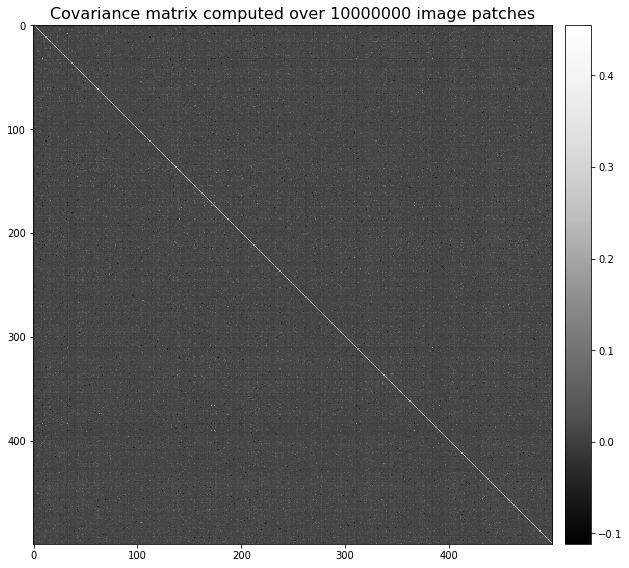

In [11]:
fig, ax = plt.subplots(1, figsize=(10,10))
im = ax.imshow(a_cov, cmap="Greys_r", interpolation="nearest")
ax.set_title("Covariance matrix computed over "+str(params["cov_num_images"])+" image patches", fontsize=16)
pf.add_colorbar(im)
plt.show()

#### Eigenvalues of the activity covariance matrix

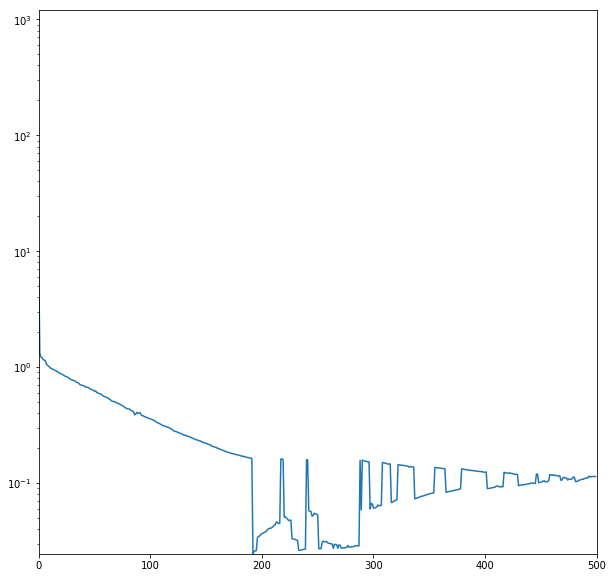

In [12]:
fig, ax = plt.subplots(1, figsize=(10,10))
ax.semilogy(a_evals)
ax.set_xlim(0, 500) # Ignore first eigenvalue
ax.set_ylim(0, 1200)
ax.set_yscale("log")
plt.show()

#### Top connected basis functions

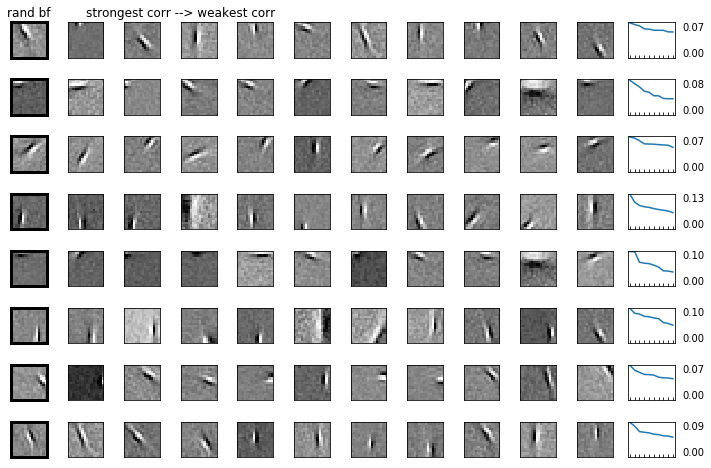

In [13]:
num_random_bases = 8
num_top_cov_bases = 10
bf_indices = np.random.choice(np.arange(a_cov.shape[0]), num_random_bases)
pf.plot_top_bases(a_cov, weights, bf_indices, num_top_cov_bases)

### Basis function analysis

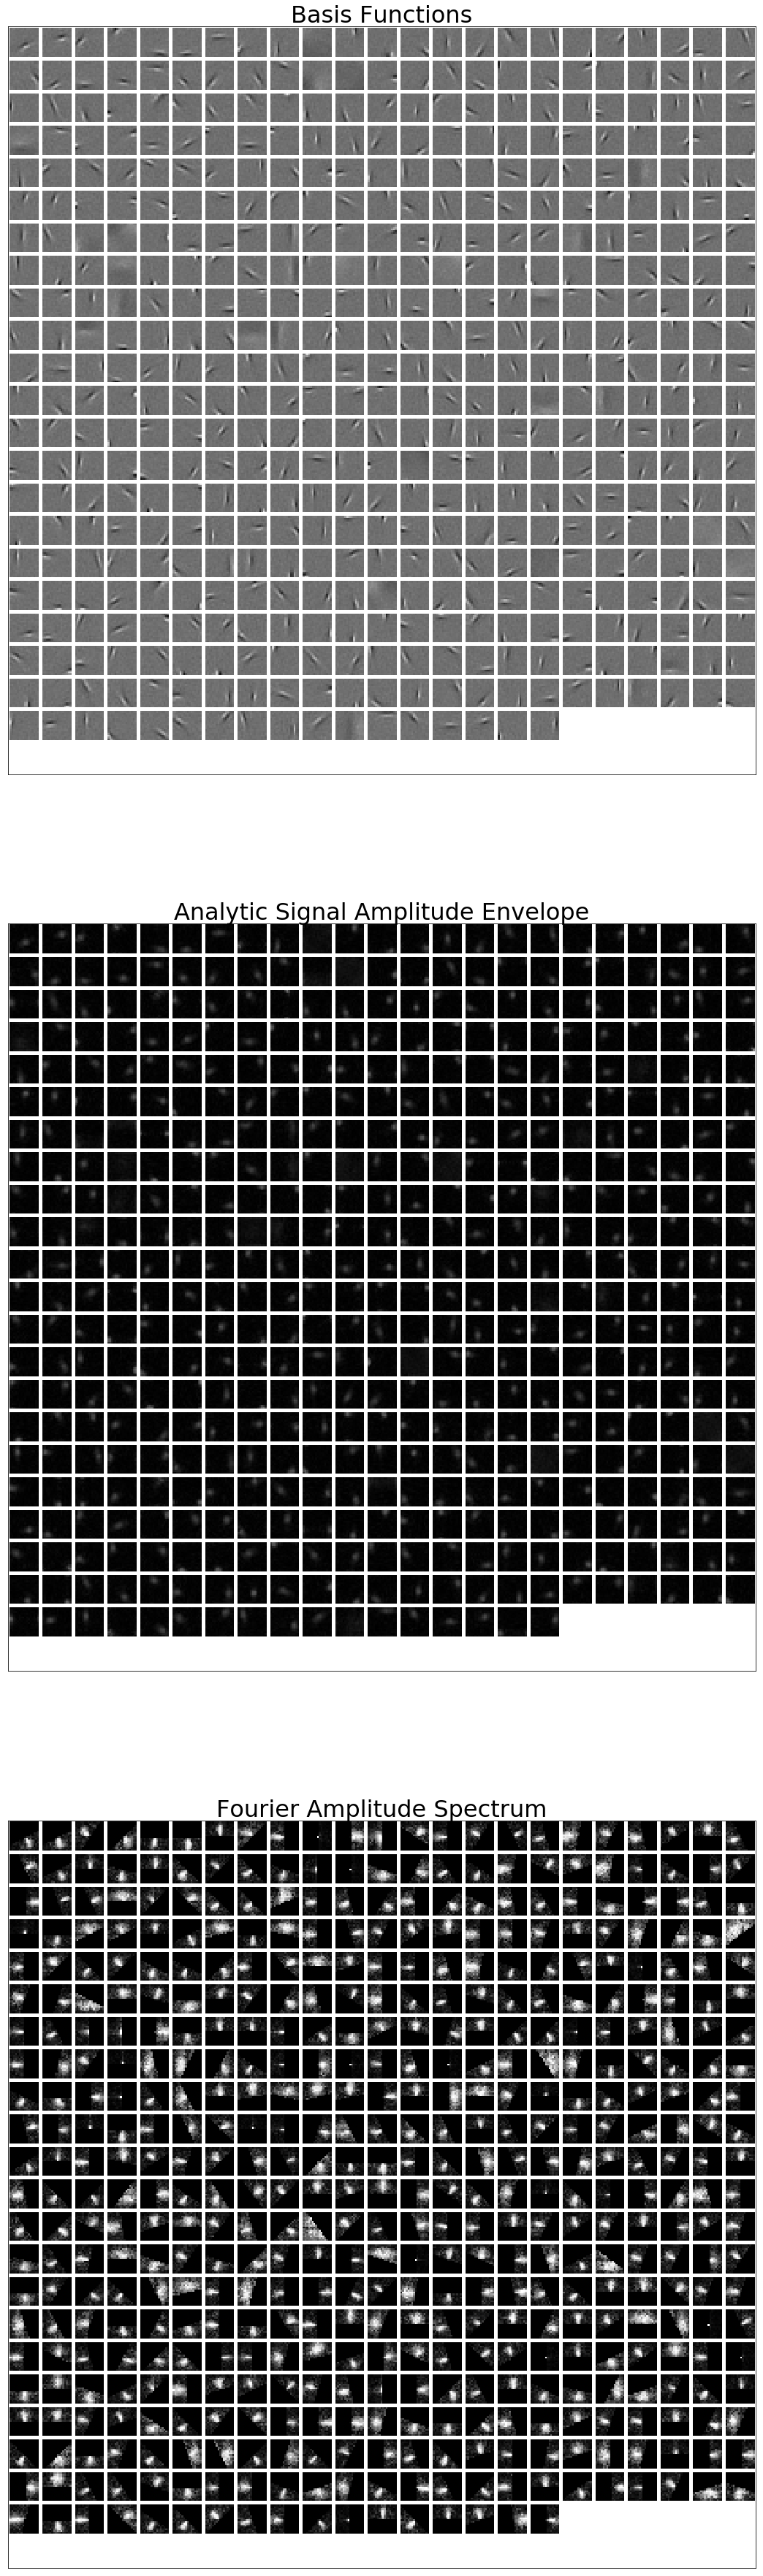

In [14]:
pf.plot_hilbert_analysis(weights)

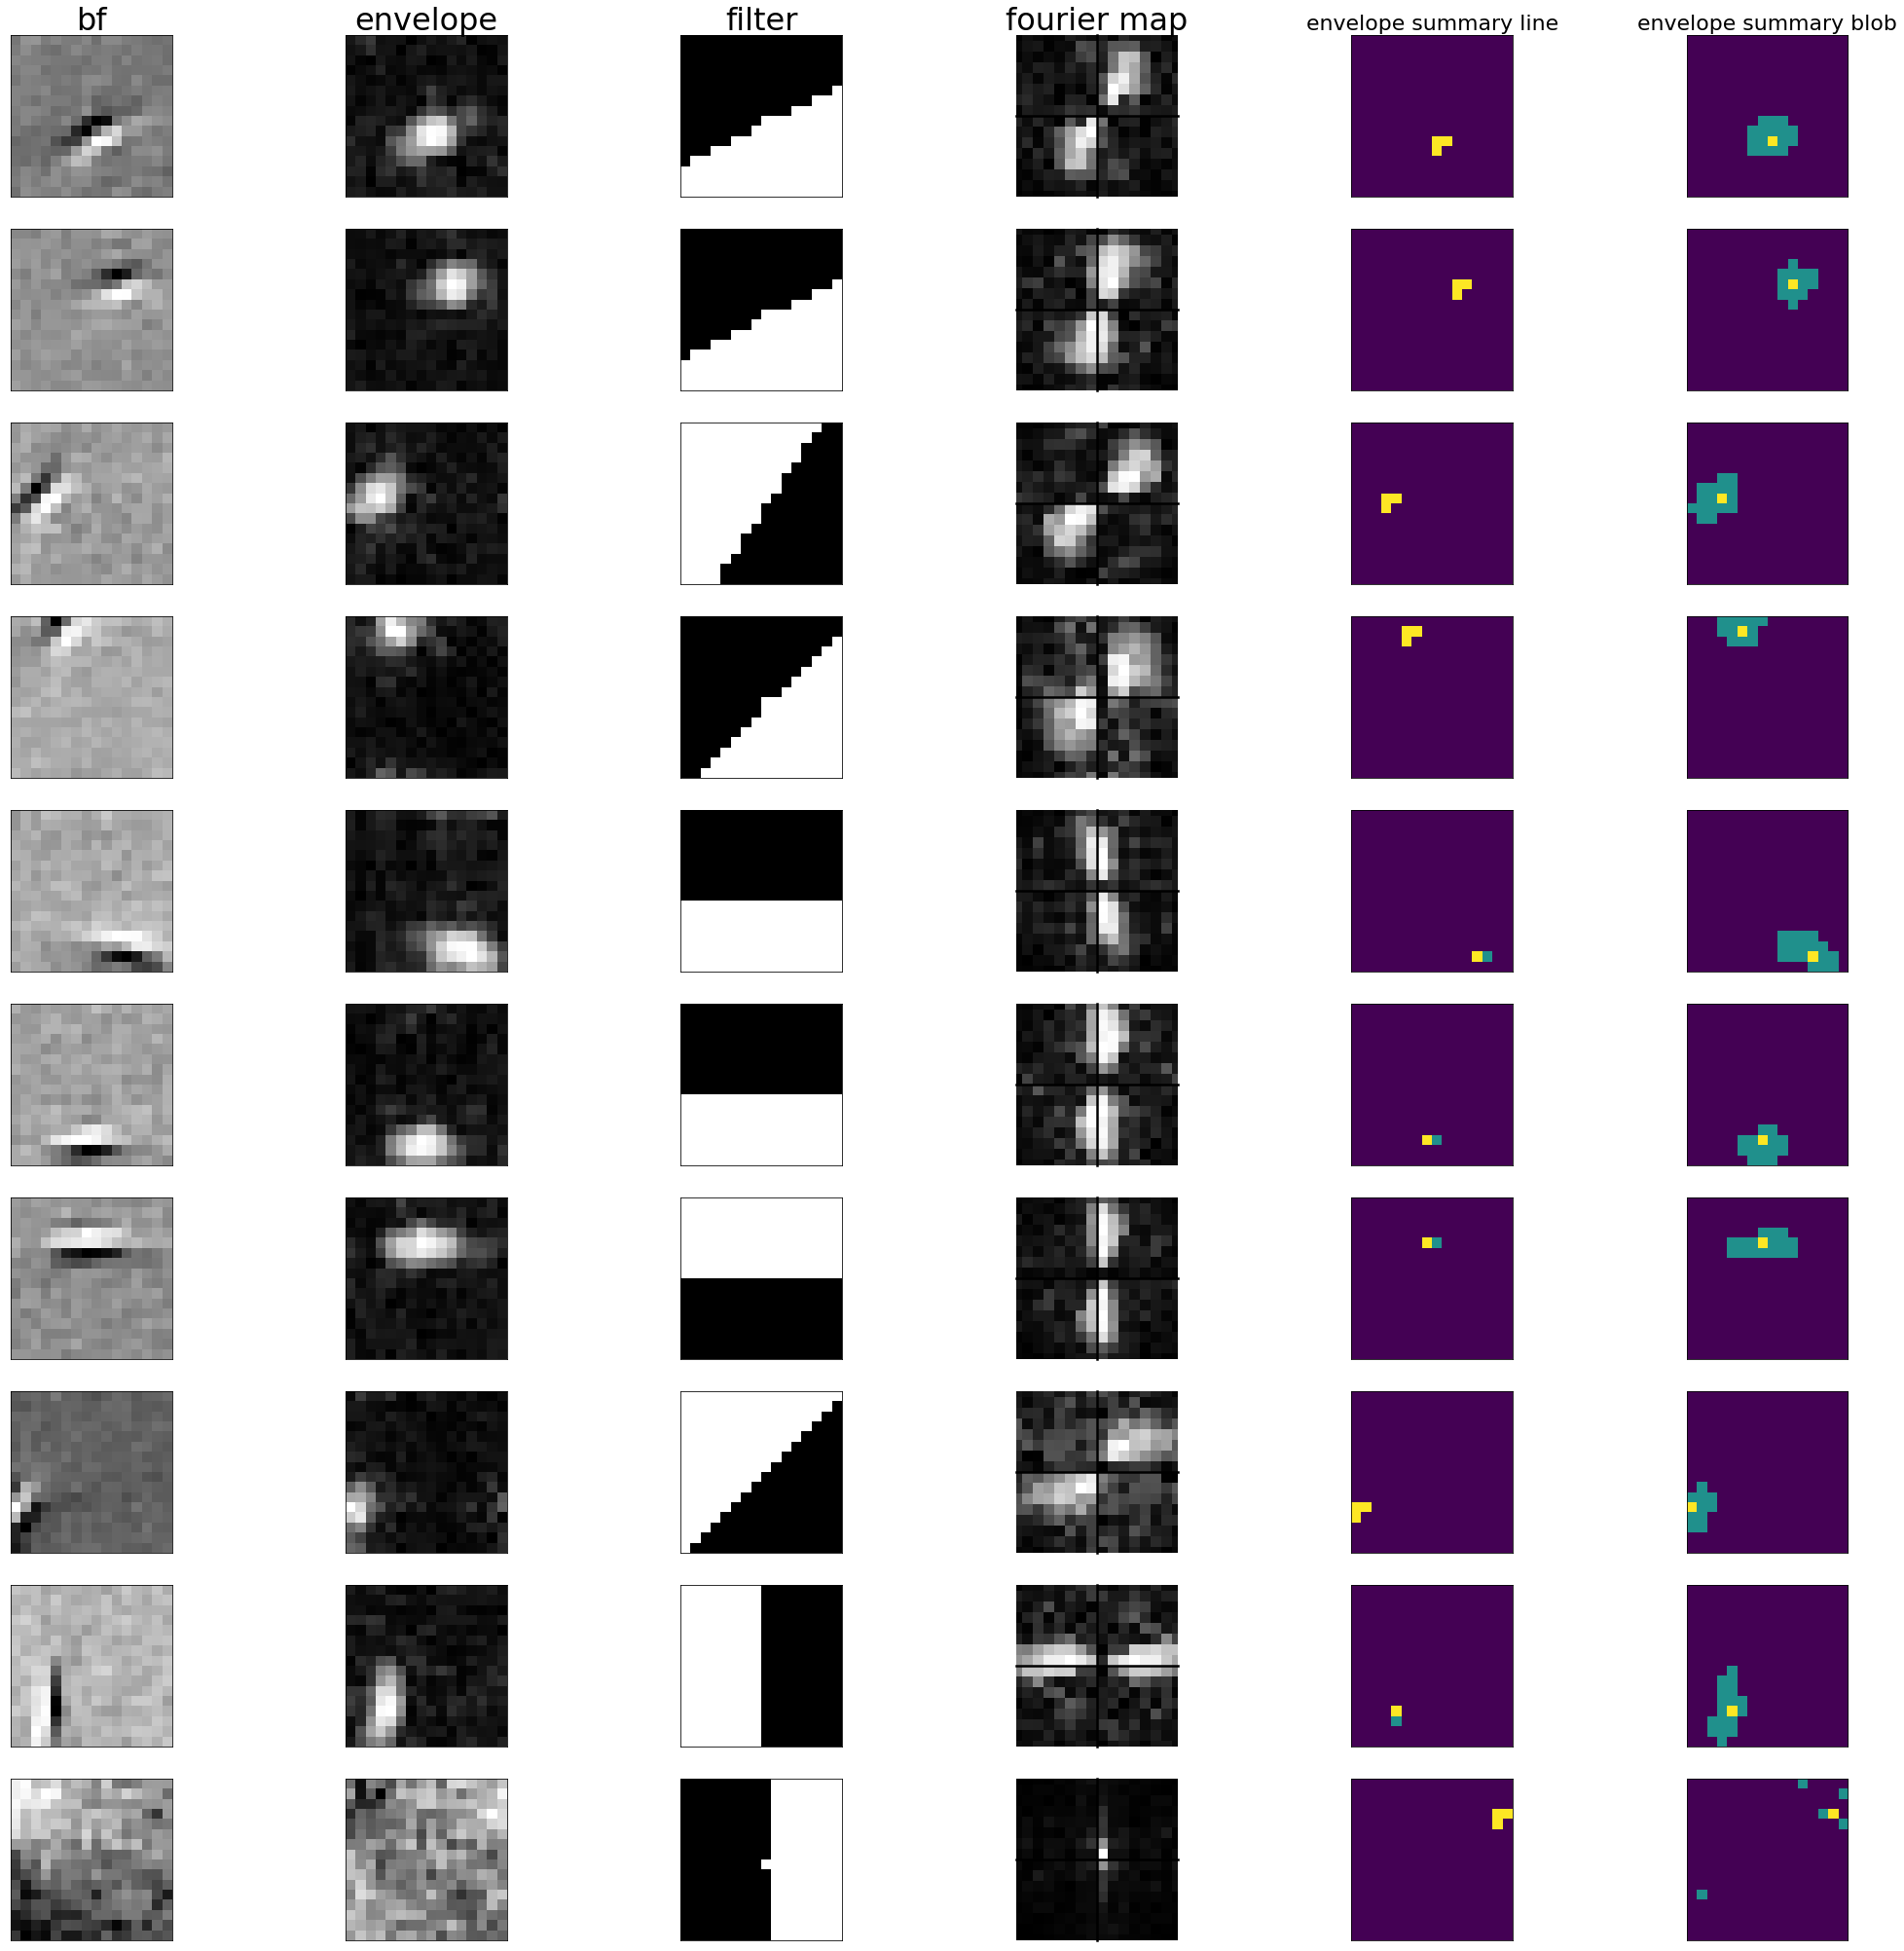

In [15]:
bf_stats = ip.get_dictionary_stats(weights)
num_bf = 10
pf.plot_bf_stats(bf_stats, num_bf)

### Pooling and eigen summary plots

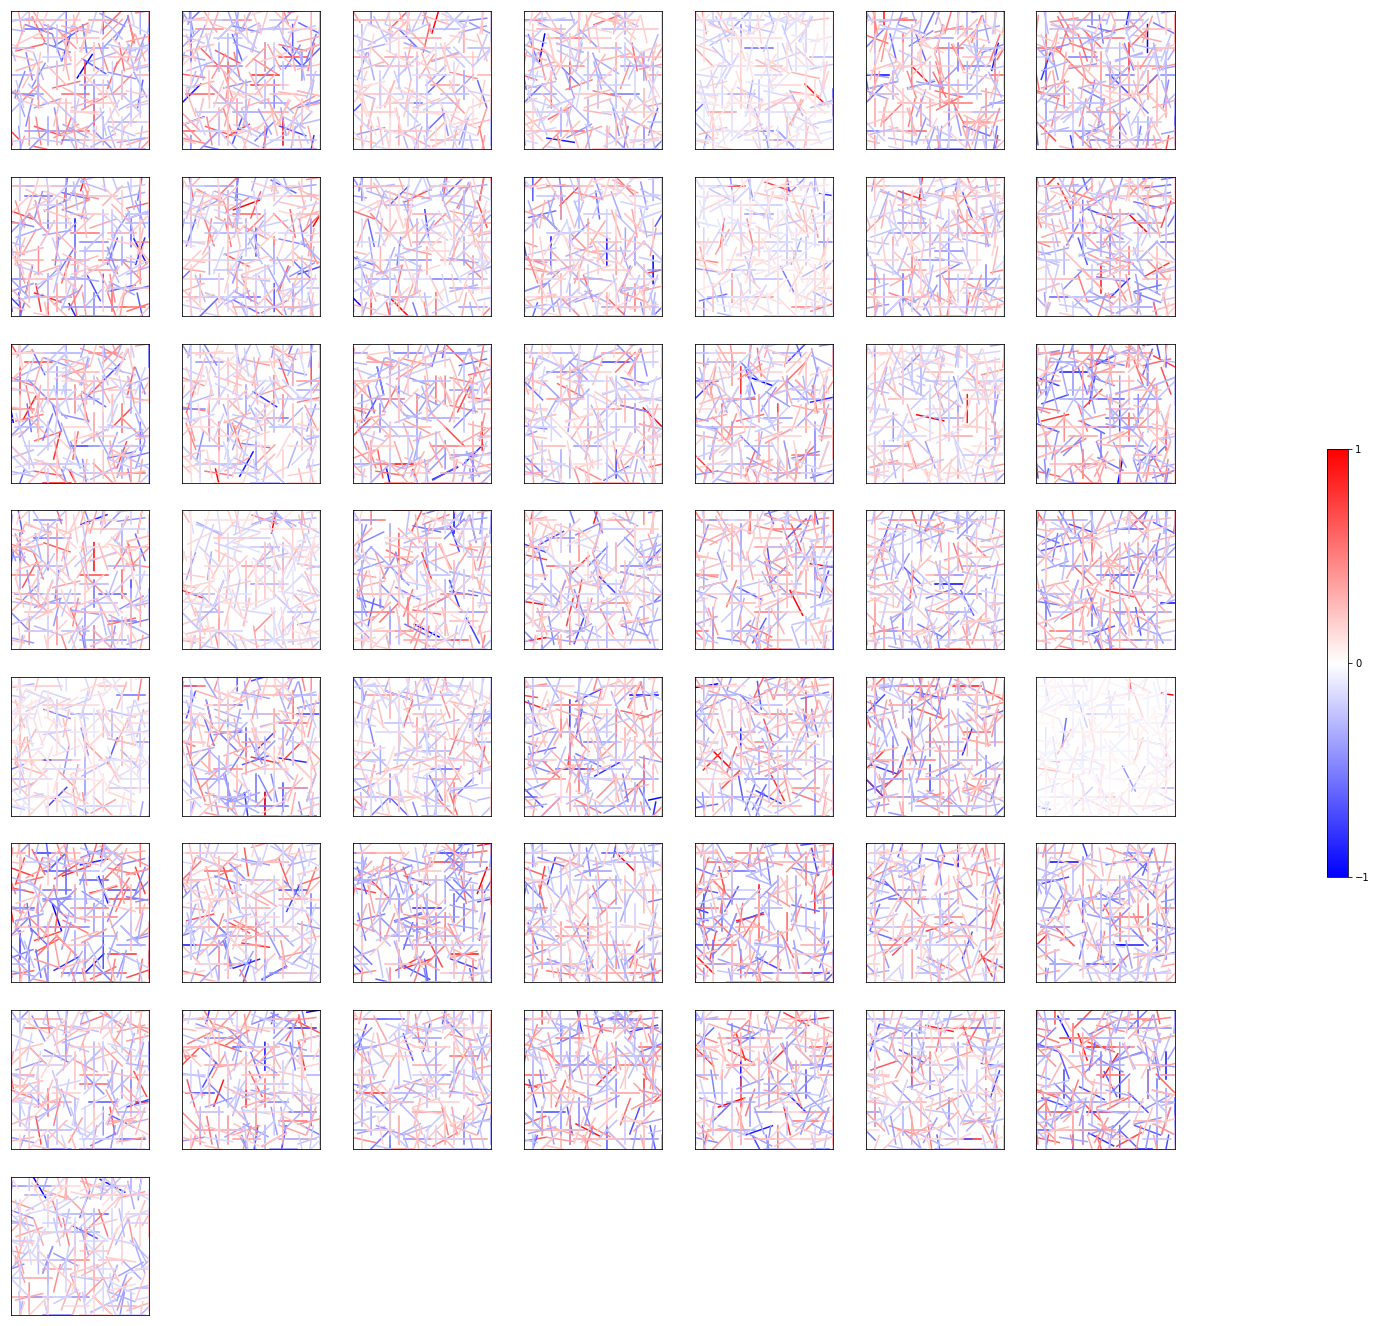

In [18]:
pf.plot_pooling_func(pf.plot_lines, weights, a_evecs[a_sort_indices[:50]],
  params["num_connected_weights"], params["num_pooling_filters"])

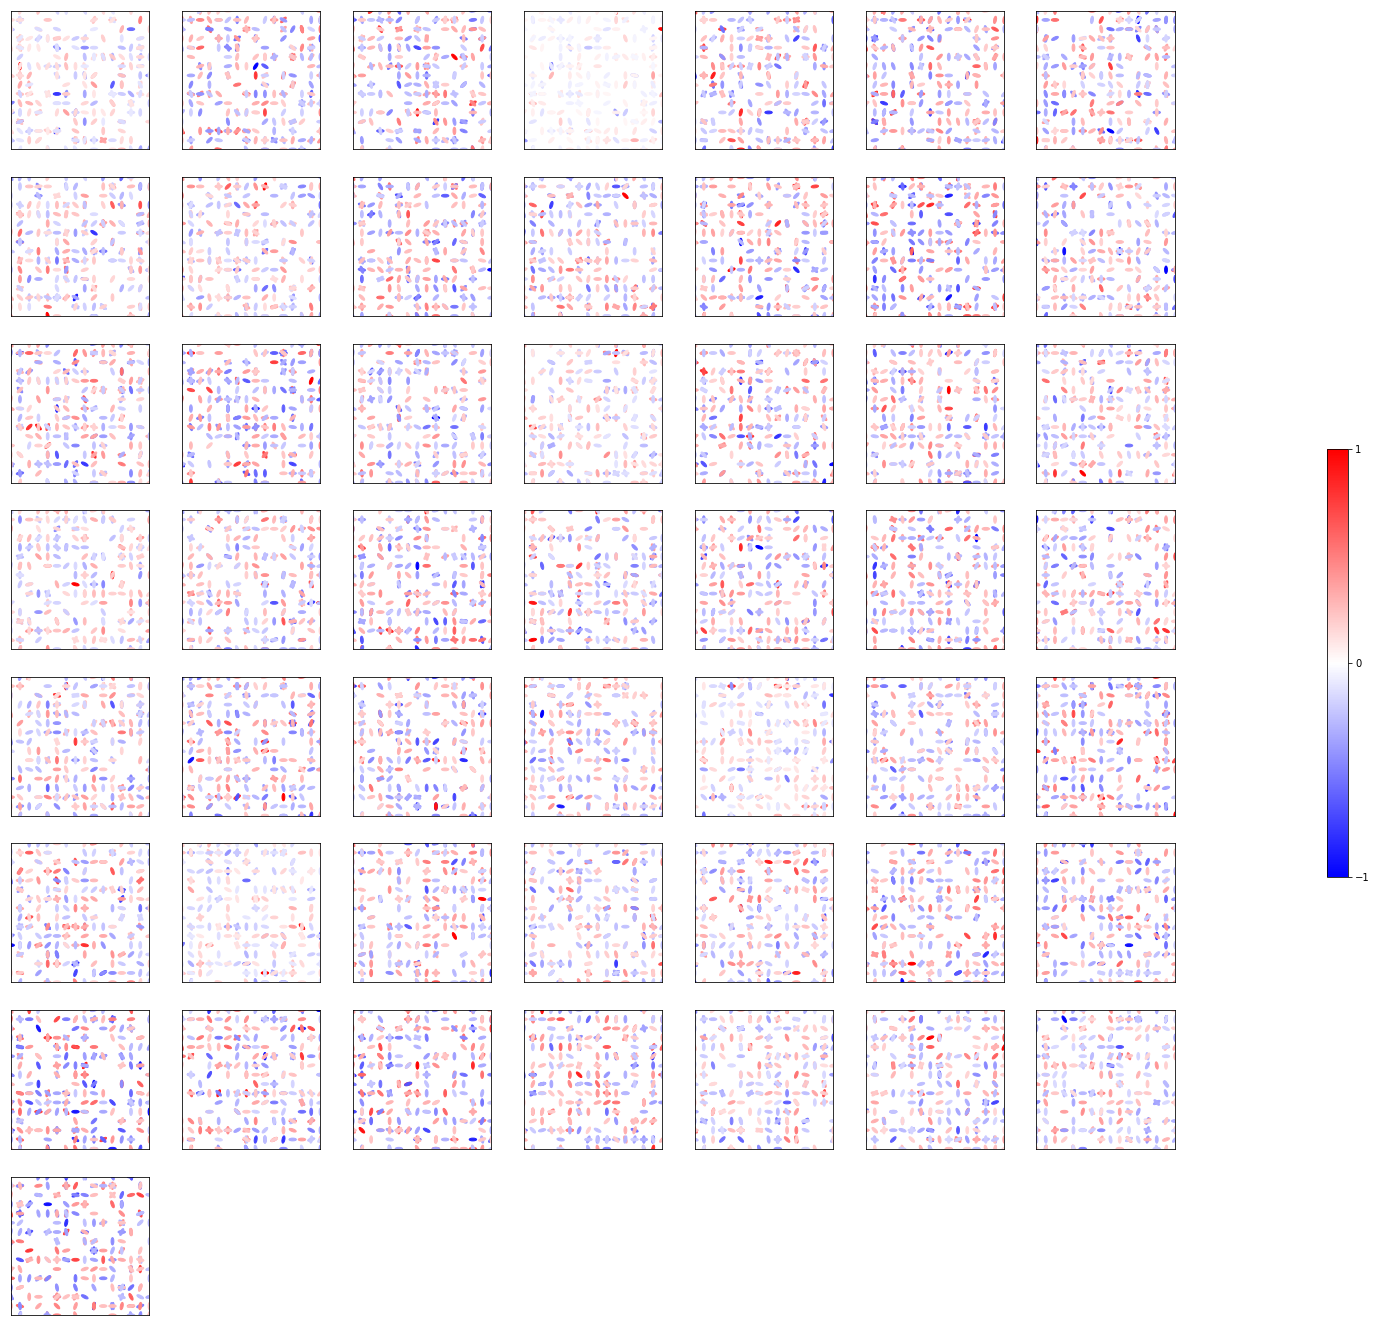

In [19]:
pf.plot_pooling_func(pf.plot_ellipse, weights, a_evecs[a_sort_indices[:50]],
  params["num_connected_weights"], params["num_pooling_filters"])

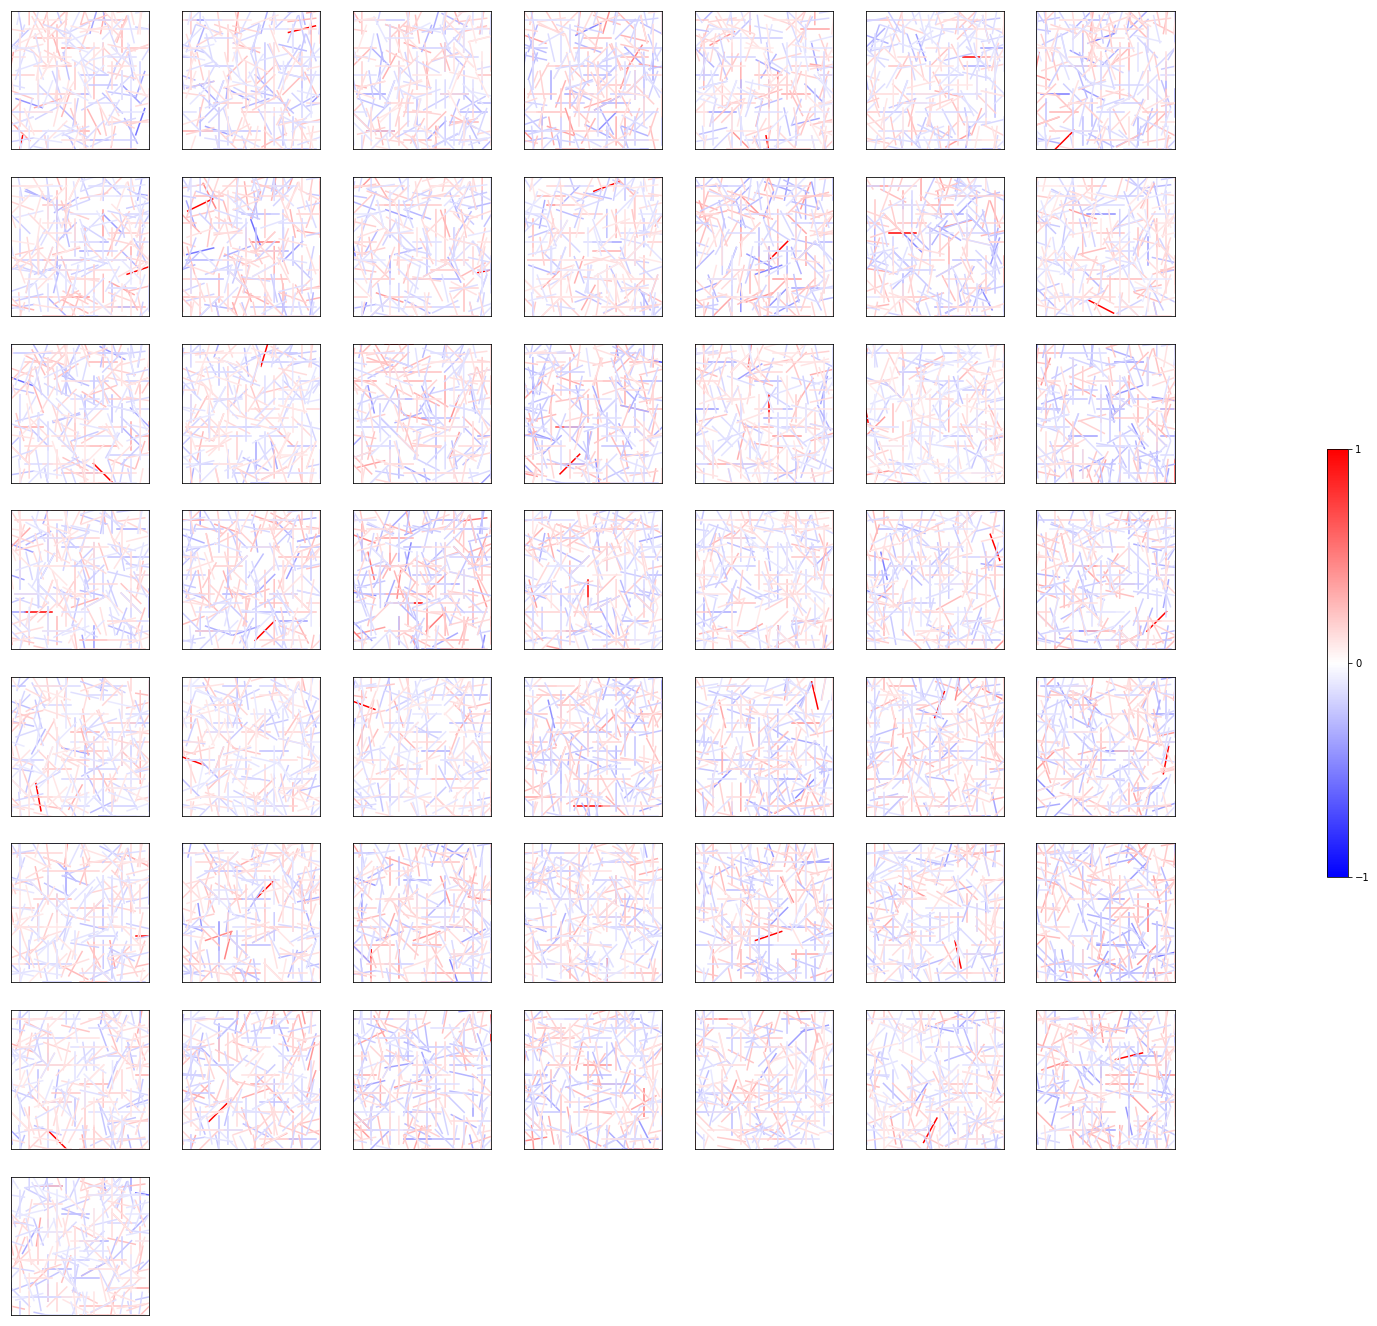

In [20]:
pf.plot_pooling_func(pf.plot_lines, weights, pooling_filters,
  params["num_connected_weights"], params["num_pooling_filters"])

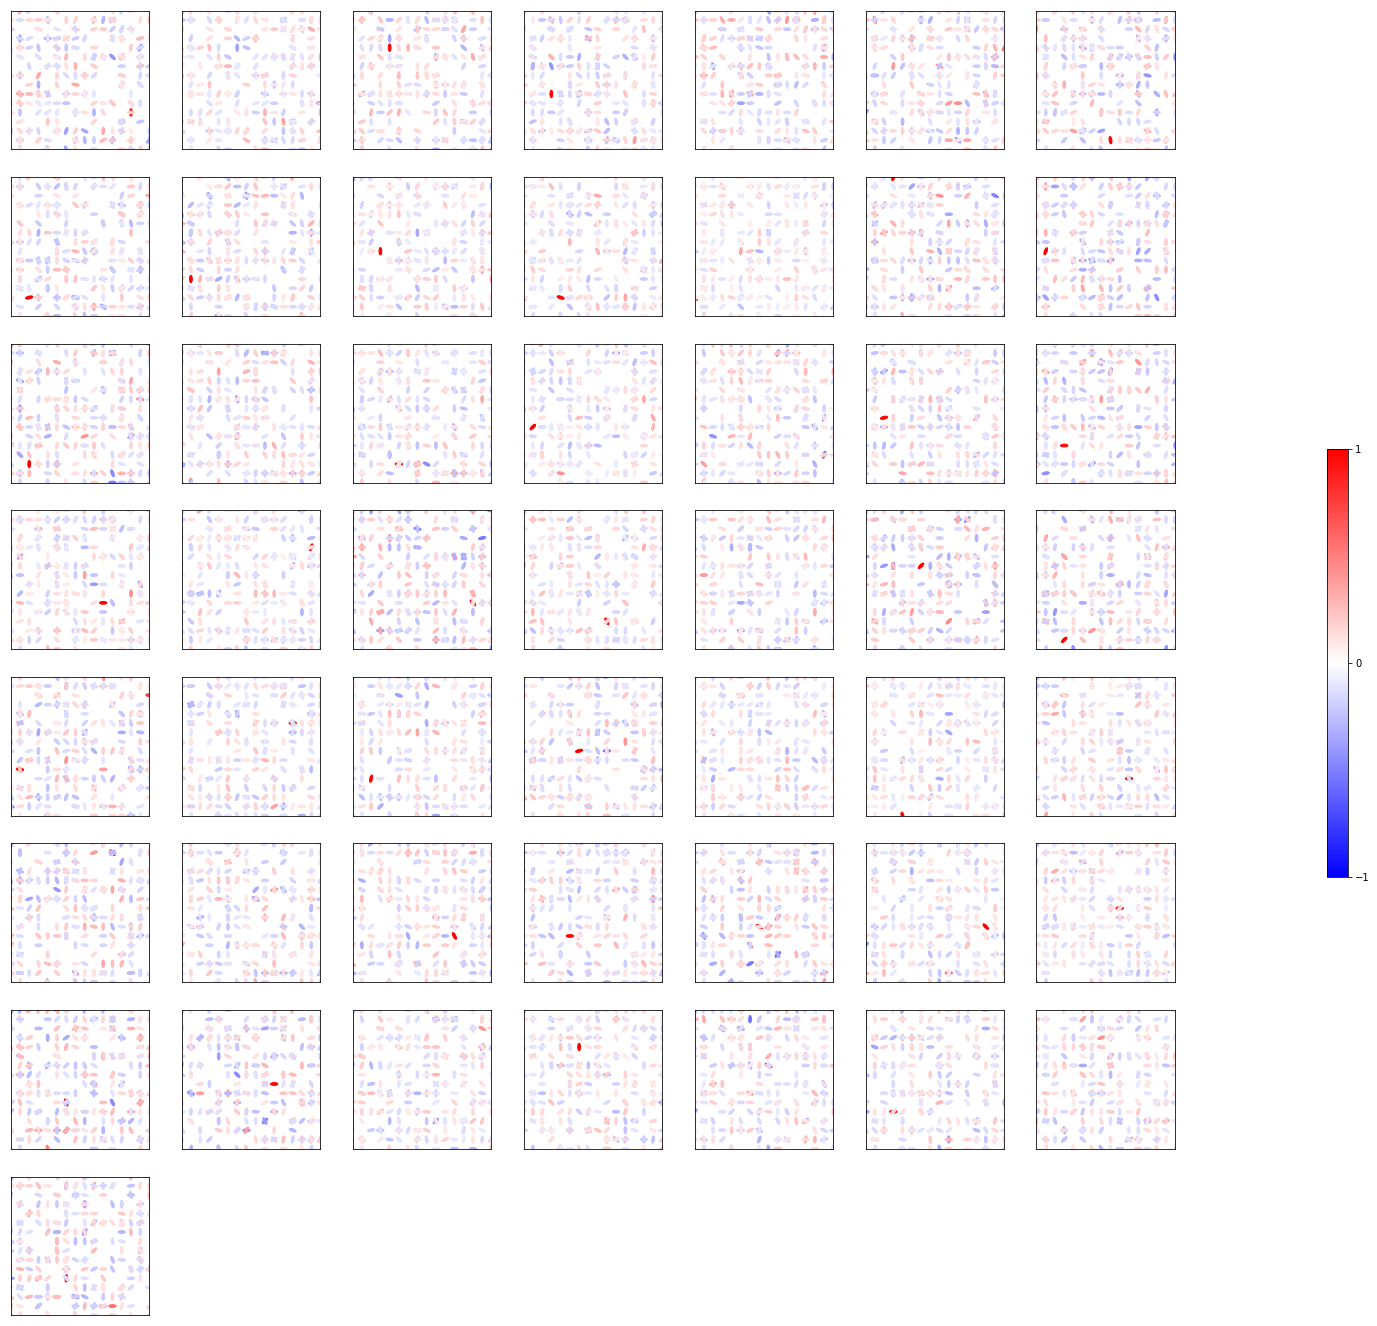

In [21]:
pf.plot_pooling_func(pf.plot_ellipse, weights, pooling_filters,
  params["num_connected_weights"], params["num_pooling_filters"])

In [22]:
"""
Generalized 2D elliptical Gaussian, following:
https://en.wikipedia.org/wiki/Gaussian_function#Two-dimensional_Gaussian_function
"""
def draw_gaussian(gridpoints, amp, mu_y, mu_x, sig_y, sig_x, theta):
  (y, x) = gridpoints
  a = (np.cos(theta)**2)/(2*sig_x**2) + (np.sin(theta)**2)/(2*sig_y**2)
  b = -(np.sin(2*theta))/(4*sig_x**2) + (np.sin(2*theta))/(4*sig_y**2)
  c = (np.sin(theta)**2)/(2*sig_x**2) + (np.cos(theta)**2)/(2*sig_y**2)
  gauss = amp * np.exp(-(a*(x-mu_x)**2 - 2*b*(x-mu_x)*(y-mu_y) + c*(y-mu_y)**2))
  return gauss.ravel()

In [23]:
def gaussian_fit(image, mean_init=None, std_init=None, theta_init=None, scale=1.0):
  assert image.ndim == 2, ("image.ndim must equal 2")
  assert image.max() <= 1.0, ("image.max must be <= 1.0")
  assert image.min() >= 0.0, ("image.min msut be >= 0.0")

  y_size, x_size = image.shape

  if mean_init is None:
    mean_init = np.hstack([np.random.rand(1)*y_size, np.random.rand(1)*x_size])
  if std_init is None:
    std_init = np.hstack([np.random.rand(1)*y_size/3, np.random.rand(1)*x_size/3])
  if theta_init is None:
    theta_init = 0

  y = np.linspace(0, y_size, np.int32(np.floor(y_size*scale)))
  x = np.linspace(0, x_size, np.int32(np.floor(x_size*scale)))
  y, x = np.meshgrid(y, x)

  init = (1.0, mean_init[0], mean_init[1], std_init[0], std_init[1], theta_init)
  popt, pcov = opt.curve_fit(draw_gaussian, (y, x), image.ravel(), p0=init)

  recon = draw_gaussian((y,x), *popt).reshape(y_size, x_size)
  return (recon, (y, x))

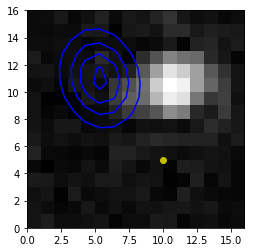

In [26]:
bf_idx = 1
bf_stats = ip.get_dictionary_stats(weights)

envelope = bf_stats["envelopes"][bf_idx]

mean_init = bf_stats["envelope_centers"][bf_idx]

(y_ang, x_ang) = bf_stats["orientations"][bf_idx]
theta_init = np.arctan2(y_ang, x_ang)

scale = 1.0

gauss_fit, grid = gaussian_fit(envelope, mean_init=mean_init, std_init=None,
  theta_init=theta_init, scale=scale)

contour_levels = 4
fig, ax = plt.subplots(1, 1)
ax.imshow(envelope, cmap="Greys_r", extent=(0, 16, 0, 16))
ax.contour(grid[1], grid[0], gauss_fit, contour_levels, colors='b')
ax.plot(mean_init[1], mean_init[0], 'yo')
plt.show()